# Dust Continuum and Extinction model
The code is based on mid-infrared dust contiuum model proposed by Donnan et al. 2024, and the dust-temperature distribution ($\Psi(T, \tau_{9.8})$) is modelled using [nifty8.re][https://ift.pages.mpcdf.de/nifty/user/index.html]. A version of the code was used to derive the mid-infrared extinction towards the Galactic Center (von Fellenberg et al. 2025). 
The dust optical depth profile $\tau(\lambda)$ is based on the Kemper et al. 2024, but is allowed to vary ($\Delta \tau(\lambda)$).
The emissivity ($\epsilon(\lambda)$) is fixed, and we use an emissivity profile based on Li & Draine 2001 (extracted from Donnan et al. 2023 and Donnan et al. 2024).

The Galactic Center does not show PHA emission, thus we do not include the lines in the fit here. The code could be trivially extended to include PHA emission as well. Similarly, as we focused on MIR extinction, we do not account for stellar emission (could also be included). 

If you find this code usefule, please cite 
von Fellenberg et al. 2025
Michail et al. 2025
and proper references to nifty8.re (consult their webpage for details). 

Please note that this is not intended as a nifty tutorial, and refere to the code authors for more detailed help and questions regarding the nifty.

In [45]:
from astropy.io import fits
import astropy.units as u 
import astropy.constants as const
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from nifty8 import re as jft
from jax import numpy as jnp
from jax import random
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic

## Some toplevel helper functions

In [54]:
def blackbody(temp, lam):
    """
    Compute B_nu for a blackbody.

    Parameters:
    -----------
    temp : float, array-like
        Temperature in Kelvin (K).
    lam : float, array-like
        Wavelength in meters (m).

    Returns:
    --------
    B_nu : 
        Blackbody spectral radiance in appropriate units.
    """
    freq = const.c.value / lam
    
    log_boltz = const.h.value * freq / (const.k_B.value * temp)
    boltzm1 = np.expm1(log_boltz)
    
    # Calculate blackbody flux
    bb_nu = (2.0 * const.h.value * freq ** 3 / (const.c.value ** 2 * boltzm1))
    return bb_nu

def blackbody0(temp_grid, emissivity=None):
    """
    Computes the integrated blackbody emission over a given wavelength range.

    Parameters:
    temp_grid (array-like): Array of temperatures (in Kelvin) for which the blackbody 
                            spectrum is computed.

    Returns:
    array: The integrated blackbody emission normalized over the wavelength range.

    Notes:
    - The wavelength range is fixed between 4.5 and 28 microns.
    - The function applies an emissivity correction before integration.
    - Integration is performed using the trapezoidal rule.
    """
    # Define the wavelength grid in meters (from 4.5 to 28 microns)
    lam0 = np.linspace(4.5, 28, 100) * 1e-6  

    # Compute the blackbody spectrum multiplied by emissivity at each wavelength
    # temp_grid[:, None] ensures proper broadcasting across wavelengths
    if emissivity is None:
        bb = poweremissivity(lam0) * blackbody(temp_grid[:, None], lam0)
    else:
        bb = emissivity(lam0) * blackbody(temp_grid[:, None], lam0)

    # Normalize by integrating over the wavelength range using the trapezoidal rule
    bb_norm = np.trapz(bb, x=lam0, axis=-1)
    return bb_norm

def poweremissivity(lam, beta=2.):
    """
    Compute the emissivity function (λ/λ₀)^(-β).

    Parameters:
    -----------
    lam : float, array-like
        Wavelength in meters (m). If float or array, assumed to be in m.
    beta : float, optional
        Emissivity spectral index (default is 2).

    Returns:
    --------
    emiss :
        The emissivity at the given wavelength(s).
    """
    # Reference wavelength
    lam0 = 9.8e-6   # 9.8 µm

    # Compute emissivity (dimensionless)
    return (lam / lam0) ** (-beta) 

# The prior silicate opacity model

In [34]:
def get_silicate_model_kemper():
    """
    silicate opacity model from Kemper et al. 2004 - please reference their work here. 
    We've extract the data from their plots, this could be improved by subsituting the "kemper" 
    array with more accurate values. At the same time, we fit for a deviation from the this law, so it is probably
    accpetable in its current state.
    """
    kemper = np.array(
        [[5.0391520e+00, 3.0472900e-01],
         [5.2395210e+00, 2.8339300e-01],
         [5.6195300e+00, 2.5611000e-01],
         [6.0962690e+00, 2.2526000e-01],
         [6.5730080e+00, 2.0092000e-01],
         [7.0082910e+00, 1.8664500e-01],
         [7.2155690e+00, 1.8306000e-01],
         [7.5886690e+00, 1.8063000e-01],
         [7.8235840e+00, 1.8828200e-01],
         [8.0377710e+00, 2.0363100e-01],
         [8.2174110e+00, 2.3022800e-01],
         [8.3625060e+00, 2.7339800e-01],
         [8.5006910e+00, 3.3313800e-01],
         [8.6596040e+00, 4.2482700e-01],
         [8.8737910e+00, 5.5200900e-01],
         [8.9774300e+00, 6.2418100e-01],
         [9.1294330e+00, 7.3303000e-01],
         [9.1985260e+00, 7.9810700e-01],
         [9.3021650e+00, 8.5489400e-01],
         [9.3919850e+00, 9.1227500e-01],
         [9.4887150e+00, 9.5190400e-01],
         [9.5992630e+00, 9.8502100e-01],
         [9.6269000e+00, 9.9507500e-01],
         [9.7512670e+00, 1.0039300e+00],
         [9.8549060e+00, 9.9030300e-01],
         [9.9792720e+00, 9.6010500e-01],
         [1.0048365e+01, 9.1571400e-01],
         [1.0200368e+01, 8.5178400e-01],
         [1.0490557e+01, 7.3457500e-01],
         [1.0780746e+01, 6.3156800e-01],
         [1.0953478e+01, 5.8656900e-01],
         [1.1105481e+01, 5.1612900e-01],
         [1.1506218e+01, 3.7700900e-01],
         [1.1955320e+01, 2.3196300e-01],
         [1.2052050e+01, 2.0946200e-01],
         [1.2204053e+01, 1.8280900e-01],
         [1.2411331e+01, 1.5200500e-01],
         [1.2729157e+01, 1.3715800e-01],
         [1.3268079e+01, 1.2996700e-01],
         [1.3779364e+01, 1.2810500e-01],
         [1.4228466e+01, 1.3098800e-01],
         [1.4663749e+01, 1.4334000e-01],
         [1.5168125e+01, 1.6633200e-01],
         [1.5672501e+01, 2.0234100e-01],
         [1.6135421e+01, 2.4131600e-01],
         [1.6494703e+01, 2.8090000e-01],
         [1.6715799e+01, 3.0157300e-01],
         [1.6985260e+01, 3.2874600e-01],
         [1.7157992e+01, 3.4765200e-01],
         [1.7413634e+01, 3.6831900e-01],
         [1.7662368e+01, 3.8543600e-01],
         [1.7890373e+01, 3.9249800e-01],
         [1.8166743e+01, 3.9304300e-01],
         [1.8380930e+01, 3.8176500e-01],
         [1.8774758e+01, 3.5566300e-01],
         [1.9237678e+01, 3.0883900e-01],
         [2.0052971e+01, 2.3355400e-01],
         [2.0515891e+01, 1.9383100e-01],
         [2.1510825e+01, 1.4159200e-01],
         [2.3120682e+01, 9.1616000e-02],
         [2.5974205e+01, 5.1489000e-02],
         [2.7908798e+01, 3.9920000e-02],
         [2.9719023e+01, 3.2514000e-02],
         [3.1957623e+01, 2.3260000e-02],
         [3.4907877e+01, 1.8028000e-02],
         [3.9025795e+01, 1.2598000e-02],])
    silicate_model = interp1d(kemper[:,0], kemper[:,1], bounds_error=False, fill_value="extrapolate")
    return silicate_model

Text(0, 0.5, '$\\tau(\\lambda)$')

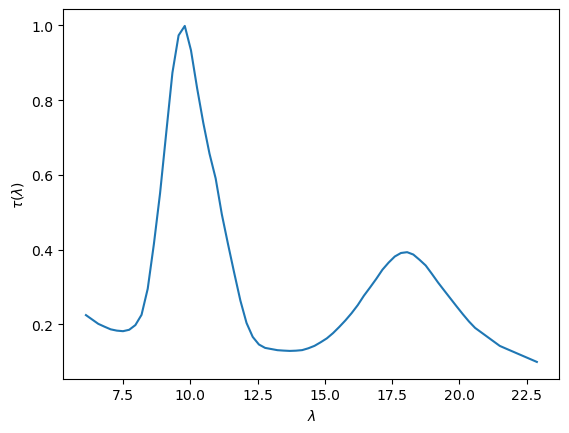

In [35]:
silicate_model = get_silicate_model_kemper()
plt.plot(obsspec[:,0], silicate_model(obsspec[:,0]))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\tau(\lambda)$")

## The dust emissivity model

In [ ]:
def get_emissivity(test=True):
    """
    Dust emissivity model that is based on Li & Draine 2001. 
    We've extrated this curve from the plots presented in Donnan 2023. 
    We use a logarithmic interpolation to obtain a fittable model, which preserves the powerlaws. 
    Note that this model has emissivity(lambda --> 0) \propto lambda ^ {-1.5}. 
    The model could be rotated to other asympotical behavior.
    The choice of silicate emissivity is a major systematic limitation, and maybe wrong for other use cases. 
    We recommend that the user take careful consideration what emissivity model to choose.
    For the code to function, the specific choice is irrelavant, it expects a python callable function. 
    We recommend log-linear interpolations to preserve powerlaw behavior.
    """
    lidraine = np.array([[2.7036640e+00, 3.1727700e-01],
       [3.0150180e+00, 2.7269000e-01],
       [3.2056580e+00, 2.3955100e-01],
       [3.5264460e+00, 2.0813500e-01],
       [4.2241530e+00, 1.7687800e-01],
       [5.3798380e+00, 1.4237700e-01],
       [6.7589880e+00, 1.3041500e-01],
       [7.7719960e+00, 1.2614200e-01],
       [8.2353200e+00, 1.4041200e-01],
       [9.2780270e+00, 3.3536900e-01],
       [9.8311330e+00, 4.0251000e-01],
       [1.0632300e+01, 3.6909900e-01],
       [1.1304580e+01, 2.6429400e-01],
       [1.2563552e+01, 1.3122400e-01],
       [1.2998862e+01, 1.1530000e-01],
       [1.4594902e+01, 1.1034800e-01],
       [1.6055406e+01, 1.5727700e-01],
       [1.7482501e+01, 1.5887800e-01],
       [1.8587919e+01, 1.6579000e-01],
       [2.1228684e+01, 1.2254400e-01],
       [2.3353028e+01, 1.0309100e-01],
       [2.6761767e+01, 7.1434000e-02],
       [3.4433586e+01, 5.1079000e-02],
       [4.9238826e+01, 3.0069000e-02],
       [5.4350945e+01, 2.4230000e-02]])

    # Create the interpolation function in log-space
    log_interp = interp1d(np.log10(lidraine[:,0]*1e-6), np.log10(lidraine[:,1]), kind='linear', fill_value='extrapolate')
    
    # Define the final interpolation function
    def emissivity(lam):
        if  isinstance(lam, u.Quantity):
            lam = lam.value
        return 10 ** log_interp(np.log10(lam))
    if test:
        plt.semilogy(lidraine[:,0],lidraine[:,1], "o")
        
    return emissivity

In [ ]:
emissivity = get_emissivity()

# The data

For testing purposes, we are providing a binned specturm extracted from an aperture centered on the Minispiral. This is for illustrative purposes only, and "obsspec" should be replaced with your data. We recommend binning data to improve the numerical complexity of the model. The binning should be coarse enough to capture all "important" features of the continuum spectrum (and PHA, stellar, ect, absorbption feautres). Here we choose linear bin-sizes, however binning could in any fashion, the purpose is a dimenionsinality reduction!

In [20]:
obsspec = np.array(
      [[ 6.11486486,  0.9329955 ],
       [ 6.34459459,  1.09939472],
       [ 6.57432432,  1.2837146 ],
       [ 6.80405405,  1.37711697],
       [ 7.03378378,  1.58546483],
       [ 7.26351351,  1.7736805 ],
       [ 7.49324324,  1.92950742],
       [ 7.72297297,  2.06659864],
       [ 7.9527027 ,  2.43261031],
       [ 8.18243243,  2.81030704],
       [ 8.41216216,  2.85115274],
       [ 8.64189189,  2.49451215],
       [ 8.87162162,  1.92873127],
       [ 9.10135135,  1.26625121],
       [ 9.33108108,  0.81069783],
       [ 9.56081081,  0.6159951 ],
       [ 9.79054054,  0.60887329],
       [10.02027027,  0.77182292],
       [10.25      ,  1.0972407 ],
       [10.47972973,  1.54879902],
       [10.70945946,  2.08225456],
       [10.93918919,  2.68876154],
       [11.16891892,  3.48911585],
       [11.39864865,  4.74183917],
       [11.62837838,  5.97615793],
       [11.85810811,  7.14270523],
       [12.08783784,  8.42999187],
       [12.31756757,  9.35472432],
       [12.5472973 ,  9.72718383],
       [12.77702703,  9.91325682],
       [13.00675676, 10.06509185],
       [13.23648649, 10.13066044],
       [13.46621622, 10.02176236],
       [13.69594595, 10.0116302 ],
       [13.92567568, 10.17262581],
       [14.15540541, 10.39404472],
       [14.38513514, 10.63185538],
       [14.61486486, 10.83585531],
       [14.84459459, 10.97029613],
       [15.07432432, 10.30897383],
       [15.30405405, 10.22998742],
       [15.53378378, 10.65503004],
       [15.76351351, 10.79405362],
       [15.99324324, 10.45390369],
       [16.22297297, 10.03302533],
       [16.4527027 ,  9.6769888 ],
       [16.68243243,  9.42193756],
       [16.91216216,  9.14371426],
       [17.14189189,  8.80341539],
       [17.37162162,  8.47027143],
       [17.60135135,  8.18791792],
       [17.83108108,  8.04351831],
       [18.06081081,  7.85885794],
       [18.29054054,  7.665383  ],
       [18.52027027,  7.6134426 ],
       [18.75      ,  7.71598574],
       [18.97972973,  7.87195331],
       [19.20945946,  8.09002177],
       [19.43918919,  8.37743524],
       [19.66891892,  8.6688711 ],
       [19.89864865,  9.00283367],
       [20.12837838,  9.31057649],
       [20.35810811,  9.58017148],
       [20.58783784,  9.74383436],
       [20.81756757,  9.78265003],
       [21.0472973 ,  9.84036618],
       [21.27702703,  9.97527259],
       [21.50675676, 10.12276508],
       [21.73648649, 10.26887843],
       [21.96621622, 10.36995739],
       [22.19594595, 10.43778003],
       [22.42567568, 10.43958599],
       [22.65540541, 10.47055534],
       [22.88513514, 10.48021081]])

Text(0, 0.5, '$\\tau(\\lambda)$')

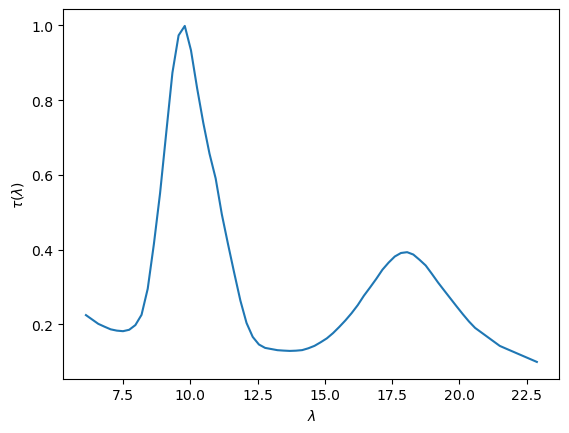

## Provide a "numerically sane" error
JWST data has very small photometric errors, however, especially for JWST/MIRI/MRS data, systematic uncertainties like fringing dominate and are poorly characterized. To obtain log-normal errors, we use simply add a 3% Gaussian error to the log-transformed data. 


/tmp/ipykernel_302622/464187849.py:4: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  synth_noise = random.normal(k_n, logmockdata.shape, logmockdata.dtype)


Text(0, 0.5, 'Flux [arg. units $\\propto F_\\nu$]')

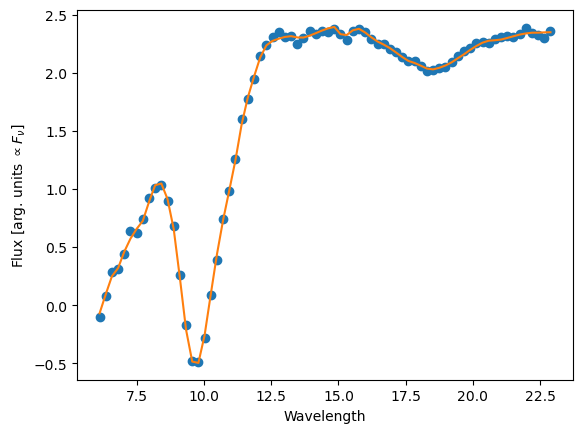

In [36]:
logmockdata = np.log(obsspec[:,1])

key, k_f, k_n = random.split(random.PRNGKey(1), 3)
synth_noise = random.normal(k_n, logmockdata.shape, logmockdata.dtype)
noise_scl = 0.03 # random units, just scaling the log(data) by eye. Note that this LogNormal noise in observed space!

synth_noise = synth_noise * noise_scl 
logmockdata_noise =  logmockdata + synth_noise

plt.plot(obsspec[:,0 ], logmockdata_noise, "o")
plt.plot(obsspec[:,0 ], logmockdata, "-")

plt.xlabel("Wavelength")
plt.ylabel(r"Flux [arg. units $\propto F_\nu$]")

# Make 1D model

In [23]:
def find_nearest_index(array, target_value):
    array = np.asarray(array)  # Ensure input is a NumPy array
    index = np.abs(array - target_value).argmin()  # Find index of closest value
    return index

In [43]:
class SimpleForward(jft.Model):
    """
    A forward model for dust emission and extinction effects in astrophysical spectra.

    This model:
    - Uses a correlated field, extinction field, and dust amplitude as parameters.
    - Computes dust emission spectra by integrating over temperature and optical depth grids.
    - Applies silicate extinction features and normalizes the continuum.
    """

    def __init__(self, correlated_field, extinction_field, amp_dust):
        """
        Initialize the SimpleForward model.

        Parameters
        ----------
        correlated_field : object
            Model or parameter field representing the correlated emission component.
        extinction_field : object
            Model or parameter field representing extinction effects.
        amp_dust : object
            Model or parameter field representing the dust amplitude scaling.
        """
        # Store input parameter fields
        self.cf        = correlated_field
        self.extinction_field = extinction_field
        self.amp_dust  = amp_dust
        
        # Define temperature grid (K) for integration
        self.temp_grid     = np.logspace(np.log10(35), np.log10(1500), 50)
        # Define optical depth (tau) grid for integration
        self.tau_grid      = np.logspace(np.log10(0.5), np.log10(10), 80)
        
        # Wavelength array from observed spectrum (microns)
        self.lam           = obsspec[:,0].copy()
        # Index of wavelength closest to 9.8 microns (silicate feature reference)
        self.idx98         = find_nearest_index(self.lam, 9.8)
        
        # Precompute integrand: emissivity × blackbody(T, λ) / normalization
        # Shape: (wavelength, temperature)
        self.integrand     = emissivity(self.lam*1e-6)[:,None] * blackbody(self.temp_grid, self.lam[:,None]*1e-6) / blackbody0(self.temp_grid)
        
        # Silicate extinction model as a function of wavelength
        self.silicate_model = silicate_model(self.lam)

        # Initialize parent model with combined parameter initializations
        super().__init__(init=self.cf.init | self.extinction_field.init | self.amp_dust.init)


    def get_integrand(self, rho, extinction_field, amp_dust):
        """
        Compute the dust continuum model given parameter values.

        Parameters
        ----------
        rho : array
            Logarithmic correlated field values.
        extinction_field : array
            Logarithmic extinction field values.
        amp_dust : array
            Dust amplitude scaling factor.

        Returns
        -------
        array
            Logarithm of the dust continuum model.
        """
        # Convert from log-space to linear
        rho              = jnp.exp(rho)
        extinction_field = jnp.exp(extinction_field) 
        
        # Apply extinction scaling to silicate opacity model and normalize at 9.8 μm
        # note that we renormalize the opacity to lambda ~ 9.8 to preserve the normalization.
        new_silicate_model = self.silicate_model * extinction_field
        new_silicate_model = new_silicate_model / new_silicate_model[self.idx98]
    
        # Compute extinction screen factor for each tau
        screen         = jnp.exp(-new_silicate_model[:,None] * self.tau_grid)
        
        # Full integrand: emission × extinction screen
        yy             = rho[None, :, :] * self.integrand[:, :, None] * screen[:, None, :]  # Ensure positivity via exponent
        
        # Integrate over temperature axis
        temp_integral  = jnp.trapezoid(yy, axis=1, x=self.temp_grid)
        # Integrate over tau axis
        tau_integral   = jnp.trapezoid(temp_integral, axis=1, x=self.tau_grid)
        # Normalize over wavelength
        norm           = jnp.trapezoid(tau_integral, x=self.lam)      
        
        # Normalize dust continuum
        # this normalization causes the input Gaussian field's amplitude to be degenerate with the amplitude parameter. 
        # in some sense, this is not necessary if there is only one emission model. In test, we've found that when including 
        # the explicit, scalar, amplitudes in the different dust components we had more robust behavior. 
        # At the same time, the degenarcy is not particularly hurtful for the interference and, 
        # for as long as one does not want units on the \Psi function it seems numerically stable. 
        # The amplitude of the dust opacity is fixed somewhat by the priors on the Gaussian Field.
        
        dust_norm      = tau_integral / norm
        dust_cont      = amp_dust * dust_norm

        return jnp.log(dust_cont) # we fit log-flux-units so here we take the log.


    def get_dust(self, x):
        """
        Compute the dust continuum model from input coordinates, with out EXTINCTION.

        Parameters
        ----------
        x : array-like
            Input coordinates for the model fields.

        Returns
        -------
        array
            Logarithm of the dust continuum model.
        """
        # Evaluate parameter fields at x
        rho, extinction_field, amp_dust = self.cf(x), self.extinction_field(x), self.amp_dust(x)

        # Convert from log-space to linear
        rho              = jnp.exp(rho)
        extinction_field = jnp.exp(extinction_field) 
        
        # Apply extinction scaling to silicate model and normalize at 9.8 μm
        new_silicate_model = self.silicate_model * extinction_field
        new_silicate_model = new_silicate_model / new_silicate_model[self.idx98]
        
        # Compute extinction screen factor
        screen         = jnp.exp(-new_silicate_model[:,None] * self.tau_grid)
        
        # Full integrand: emission × extinction screen
        yy             = rho[None, :, :] * self.integrand[:, :, None] * screen[:, None, :]
        
        # Integrate over temperature axis
        temp_integral  = jnp.trapezoid(yy, axis=1, x=self.temp_grid)
        # Integrate over tau axis
        tau_integral   = jnp.trapezoid(temp_integral, axis=1, x=self.tau_grid)
        # Normalize over wavelength
        norm           = jnp.trapezoid(tau_integral, x=self.lam)      
        
        # Normalize dust continuum
        dust_norm      = tau_integral / norm
        dust_cont      = amp_dust * dust_norm
        
        return jnp.log(dust_cont)
        

    def get_intrinisic(self, x):
        """
        Compute the intrinsic (unextincted) dust continuum model.

        Parameters
        ----------
        x : array-like
            Input coordinates for the model fields.

        Returns
        -------
        array
            Logarithm of the intrinsic dust continuum model.
        """
        # Evaluate parameter fields at x
        rho, extinction_field, amp_dust = self.cf(x), self.extinction_field(x), self.amp_dust(x)
        
        # Convert from log-space to linear
        rho              = jnp.exp(rho)
        extinction_field = jnp.exp(extinction_field) 
        
        # Apply extinction scaling to silicate model and normalize at 9.8 μm
        new_silicate_model = self.silicate_model * extinction_field
        new_silicate_model = new_silicate_model / new_silicate_model[self.idx98]
        
        # Compute extinction screen factor
        screen         = jnp.exp(-new_silicate_model[:,None] * self.tau_grid)
        
        # Compute attenuated continuum
        yy             = rho[None, :, :] * self.integrand[:, :, None] * screen[:, None, :]
        temp_integral  = jnp.trapezoid(yy, axis=1, x=self.temp_grid)
        tau_integral   = jnp.trapezoid(temp_integral, axis=1, x=self.tau_grid)
        norm           = jnp.trapezoid(tau_integral, x=self.lam)      

        # Compute continuum again without extinction screen, using same normalization
        yy             = rho[None, :, :] * self.integrand[:, :, None]
        temp_integral  = jnp.trapezoid(yy, axis=1, x=self.temp_grid)
        tau_integral   = jnp.trapezoid(temp_integral, axis=1, x=self.tau_grid)
        
        # Normalize dust continuum
        dust_norm      = tau_integral / norm
        dust_cont      = amp_dust * dust_norm

        return jnp.log(dust_cont)  # Fit log of data and model
    
    
    def __call__(self, x):
        """
        Callable interface for the model.

        Parameters
        ----------
        x : array-like
            Input coordinates for the model fields.

        Returns
        -------
        array
            Logarithm of the dust continuum model.
        """
        return self.get_integrand(self.cf(x), self.extinction_field(x), self.amp_dust(x))


# Generation of the 2 correlated fields
the first field (simpl_field) corresponds to the $\Psi(T, \tau_{9.8})$ function. simple is a misnomer
the second field (tau_field) corresponds to the $\Delta \tau(\lambda)$
The amplitude of the dust is given by (eq. in Donnan 2024)

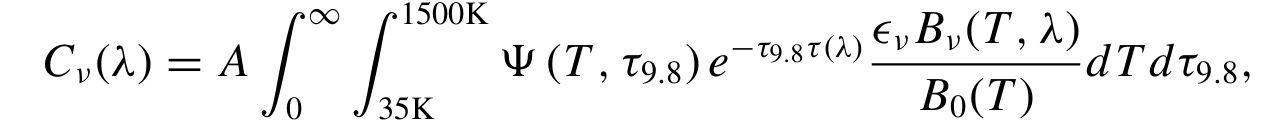

## fix hyper parameters to macht rough mean of the data 

These hyper parameters worked for the data in von Fellenberg 2025. Most likely they will work for other data as well. Still, you might want to tweak them a little - take a look at the nifty documenation for suggestions how.

In [48]:
dims = (50,80) # (temp, tau)
simp_cfm = jft.CorrelatedFieldMaker("dust_field")
simp_cfm.set_amplitude_total_offset(offset_mean=0, offset_std=(1, 1e-3)) # low
simp_cfm.add_fluctuations(  # Axis over which the kernel is defined
  dims,
  distances=tuple(1.0 / d for d in dims),
  fluctuations=(0.1, 0.1), # small
  loglogavgslope=(-5, 2), # steep
  flexibility=(0.5, 0.5),
  asperity=None, #for periodic signal
  prefix="dust_",
  non_parametric_kind="power",
)
simplfield = simp_cfm.finalize()  # forward model for a GP prior

/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/correlated_field.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  m_length = jnp.arange(shape[0], dtype=jnp.float64)
/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/correlated_field.py:169: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  tmp = jnp.arange(shape[i], dtype=jnp.float64)


/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/tree_math/forest_math.py:70: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return rng(key=key, shape=shp, dtype=dtp)


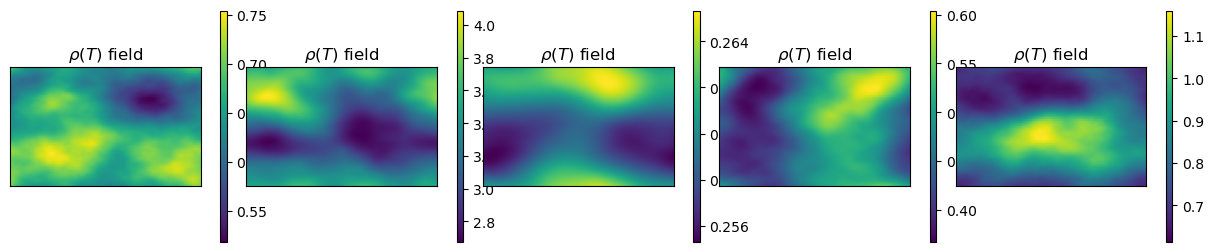

In [49]:
fig, axes = plt.subplots(1,10, figsize=(5*3, 3), gridspec_kw={"width_ratios":[3,0.1, 3,0.1, 3,0.1, 3,0.1, 3,0.1]})
for num, n in enumerate(np.random.randint(0,1000, 5)):
    num = num*2
    testkey, testsubkey = random.split(random.PRNGKey(n))
    prior1_position = jft.Vector(simplfield.init(testsubkey))
    prior_rho      = simplfield(prior1_position)
    
    ax = axes[num].imshow(jnp.exp(prior_rho[:,:,]))
    plt.colorbar(ax, cax=axes[num+1])
    
    axes[num].xaxis.set_visible(False)
    axes[num].yaxis.set_visible(False)

    axes[num].set_title(r"$\rho(T)$ field")
    axes[num].set_xlabel(r"$T$ [K]")

In [50]:
dims = len(obsspec) # (temp, tau)
tau_cfm = jft.CorrelatedFieldMaker("tau_field")
tau_cfm.set_amplitude_total_offset(offset_mean=0, offset_std=(0.1, 1e-3)) # low
tau_cfm.add_fluctuations(  # Axis over which the kernel is defined
  dims,
  distances=1/dims,
  fluctuations=(0.01, 0.01), # small
  loglogavgslope=(-4, 2), # steep
  flexibility=(0.2, 0.2),
  asperity=None, #for periodic signal
  prefix="tau_",
  non_parametric_kind="power",
)
tau_field = tau_cfm.finalize()  # forward model for a GP prior

/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/correlated_field.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  m_length = jnp.arange(shape[0], dtype=jnp.float64)


/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/tree_math/forest_math.py:70: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return rng(key=key, shape=shp, dtype=dtp)


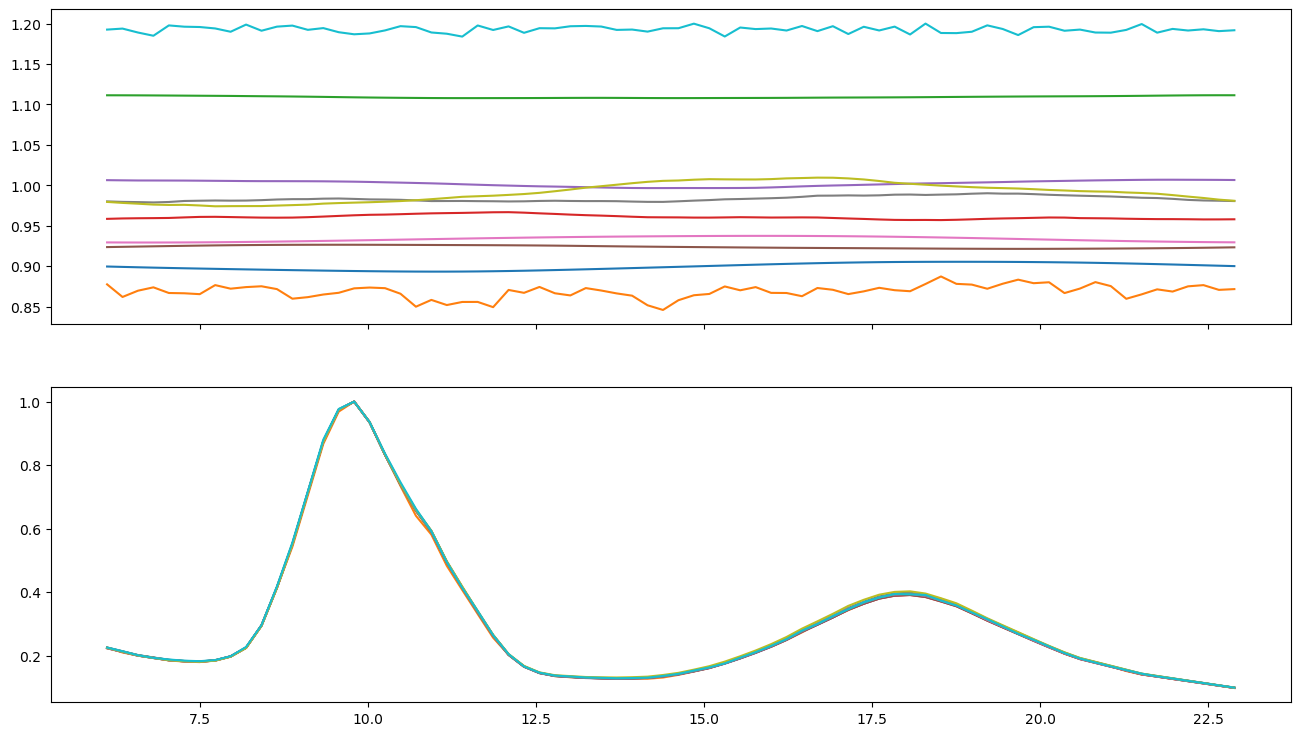

In [51]:
fig, axes = plt.subplots(2,1, figsize=(16,9), sharex=True)
for num, n in enumerate(np.random.randint(0,1000, 10)):
    testkey, testsubkey = random.split(random.PRNGKey(n))
    prior1_position = jft.Vector(tau_field.init(testsubkey))
    _ = tau_field(prior1_position)
    axes[0].plot(obsspec[:,0], jnp.exp(_))
    _ = jnp.exp(_) * silicate_model(obsspec[:,0],) 
    _ =  _/_[find_nearest_index(obsspec[:,0], 9.8)]
    axes[1].plot(obsspec[:,0], _)
    
    

In [52]:
amp_dust = jft.UniformPrior(0.1, 1000, name="dust_amp", shape=(1,))


In [55]:
simpleforward = SimpleForward(simplfield, tau_field, amp_dust)

/tmp/ipykernel_302622/2296152646.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bb_norm = np.trapz(bb, x=lam0, axis=-1)
/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/tree_math/forest_math.py:70: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return rng(key=key, shape=shp, dtype=dtp)


### the likelihood object

In [56]:
lh = jft.Gaussian(logmockdata_noise, noise_cov_inv=1.0 / synth_noise**2).amend(simpleforward)

assuming the specified inverse covariance is diagonal
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


/homes/sfellenberg/.local/lib/python3.10/site-packages/nifty8/re/tree_math/forest_math.py:70: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return rng(key=key, shape=shp, dtype=dtp)


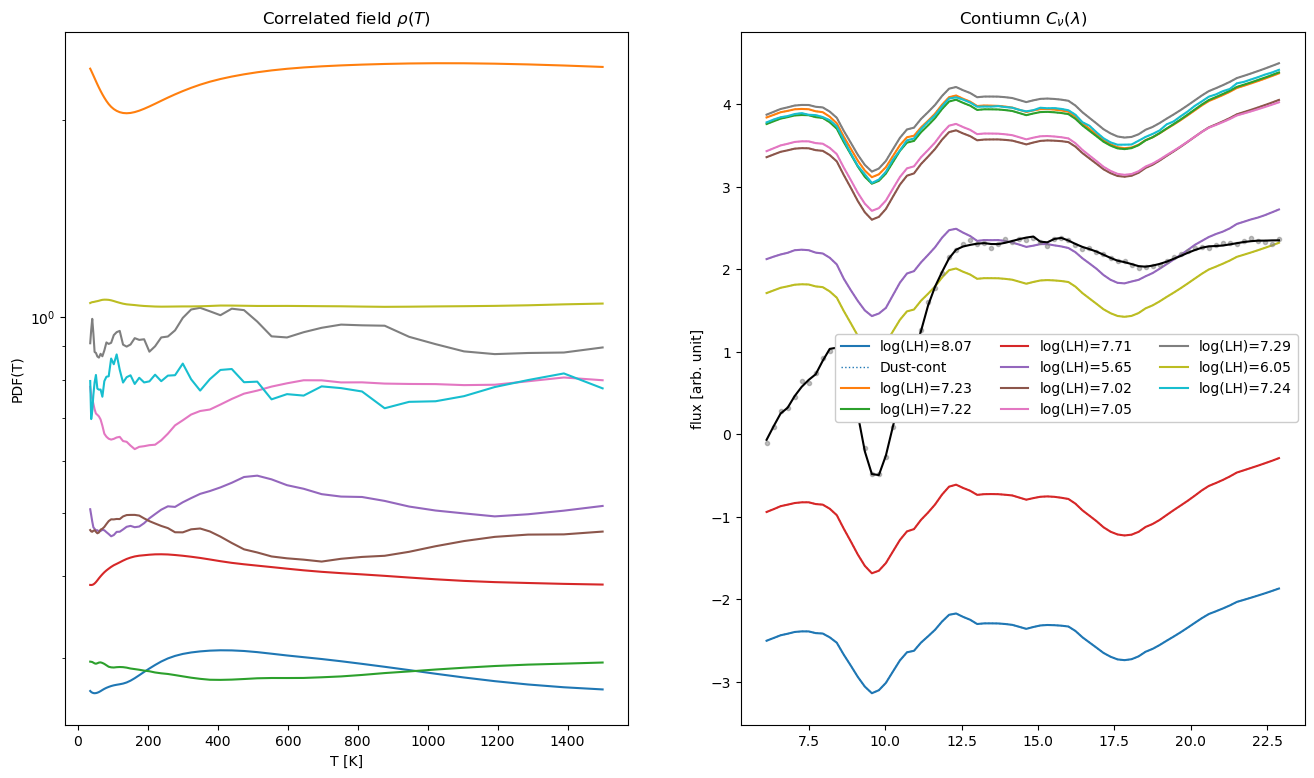

In [57]:
fig, axes = plt.subplots(1,2, figsize=(16,9))

for num, n in enumerate(np.random.randint(0,1000, 10)):
    testkey, testsubkey = random.split(random.PRNGKey(n))
    prior1_position = jft.Vector(simpleforward.init(testsubkey))
    axes[0].semilogy(simpleforward.temp_grid, np.exp(simplfield(prior1_position)[:,0]), color="C"+str(num))
    
    axes[1].plot(simpleforward.lam,     simpleforward(prior1_position), color="C"+str(num), label="log(LH)="+str(round(np.log10(lh(prior1_position)),2)))
    if num == 0:
        axes[1].plot(simpleforward.lam,     simpleforward.get_dust(prior1_position), lw=1, color="C"+str(num), ls=":", label="Dust-cont")
    else:
        axes[1].plot(simpleforward.lam,     simpleforward.get_dust(prior1_position), lw=1, color="C"+str(num), ls=":")
    
    
axes[0].set_title(r"Correlated field $\rho(T)$")
axes[1].set_title(r"Contiumn $C_\nu(\lambda)$")

axes[1].errorbar(simpleforward.lam, logmockdata_noise, fmt=".", c="grey", alpha=0.5)
axes[1].errorbar(simpleforward.lam, logmockdata, fmt="-", c="k", alpha=1)

axes[1].set_ylabel("lambda [micron]")
axes[1].set_ylabel("flux [arb. unit]")
axes[0].set_ylabel("PDF(T)")
axes[0].set_xlabel("T [K]")
axes[1].legend(ncol=3, fontsize=10,framealpha=1.)

### the VI inference

Below is a helper function to take care of the optimization kindly provided by JongSeo Kim and Julian Ruestig.

In [58]:
def get_samples(key, n_vi_iterations=3, delta=1e-4, n_samples=5, maxiter_SN=10, maxiter_M=50, maxiter_SL=100):
    key, k_i, k_o = random.split(random.PRNGKey(key), 3) # 3 was good
    # NOTE, changing the number of samples always triggers a resampling even if
    # `resamples=False`, as more samples have to be drawn that did not exist before.
    _samples, _state = jft.optimize_kl(
        lh,
        jft.Vector(lh.init(k_i)),
        n_total_iterations=n_vi_iterations,
        n_samples=lambda i: n_samples // 2 if i < 2 else n_samples,
        # Source for the stochasticity for sampling
        key=k_o,
        # Names of parameters that should not be sampled but still optimized
        # can be specified as point_estimates (effectively we are doing MAP for
        # these degrees of freedom).
        # point_estimates=("cfax1flexibility", "cfax1asperity"),
        # Arguments for the conjugate gradient method used to drawing samples
        draw_linear_kwargs=dict(
            cg_name="SL",
            cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=maxiter_SL),
        ),
        # Arguements for the minimizer in the nonlinear updating of the samples
        nonlinearly_update_kwargs=dict(
            minimize_kwargs=dict(
                name="SN",
                xtol=delta,
                cg_kwargs=dict(name=None),
                maxiter=maxiter_SN,
            )
        ),
        # Arguments for the minimizer of the KL-divergence cost potential
        kl_kwargs=dict(
            minimize_kwargs=dict(
                name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=maxiter_M
            )
        ),
        sample_mode="nonlinear_resample",
        odir="minispiral_sample",
        resume=False,
    )
    return _samples

To generate a lot of posterior samples we loop over a couple of random seeds. 
We found some random seeds to fail inexplicatbly and simple capture those by execption.

In [ ]:
samples = []
for key in range(0, 30):
    try:
        _ = get_samples(key, n_vi_iterations=6, maxiter_SN=20)
        samples = samples + list(_)
    except:
        print(key)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+7.7036e+04 Δ⛰:inf ➽:5.3090e-02
SL: Iteration 1 ⛰:-2.6670e+03 Δ⛰:7.9703e+04 ➽:5.3090e-02
SL: Iteration 2 ⛰:-2.6809e+03 Δ⛰:1.3910e+01 ➽:5.3090e-02
SL: Iteration 3 ⛰:-2.6809e+03 Δ⛰:1.0010e-02 ➽:5.3090e-02
SL: Iteration 4 ⛰:-2.6822e+03 Δ⛰:1.2644e+00 ➽:5.3090e-02
SL: Iteration 5 ⛰:-2.6837e+03 Δ⛰:1.5012e+00 ➽:5.3090e-02
SL: Iteration 6 ⛰:-2.6837e+03 Δ⛰:1.4648e-03 ➽:5.3090e-02
SL: Iteration 0 ⛰:+8.2243e+04 Δ⛰:inf ➽:5.3090e-02
SL: Iteration 1 ⛰:-2.5505e+03 Δ⛰:8.4794e+04 ➽:5.3090e-02
SL: Iteration 2 ⛰:-2.5926e+03 Δ⛰:4.2132e+01 ➽:5.3090e-02
SL: Iteration 3 ⛰:-2.5927e+03 Δ⛰:3.9551e-02 ➽:5.3090e-02
SL: Iteration 4 ⛰:-2.5975e+03 Δ⛰:4.8181e+00 ➽:5.3090e-02
SL: Iteration 5 ⛰:-2.6063e+03 Δ⛰:8.7742e+00 ➽:5.3090e-02
SL: Iteration 6 ⛰:-2.6063e+03 Δ⛰:2.4414e-04 ➽:5.3090e-02
SN: →:1.0 ↺:False #∇²:06 |↘|:6.720341e-01 🞋:5.309000e-01
SN: Iteration 1 ⛰:+4.069698e+00 Δ⛰:6.821040e+03
SN: →:1.0 ↺:False #∇²:12 |↘|:3.661495e-01 🞋:5.309000e-01
SN: Iteration 2 ⛰:+3.213818

0


SL: Iteration 8 ⛰:-2.6114e+03 Δ⛰:5.9814e-02 ➽:5.3090e-02
SL: Iteration 9 ⛰:-2.6115e+03 Δ⛰:2.2461e-02 ➽:5.3090e-02
SN: →:1.0 ↺:False #∇²:06 |↘|:1.974510e+00 🞋:5.309000e-01
SN: Iteration 1 ⛰:+1.694216e+02 Δ⛰:7.956840e+04
SN: →:1.0 ↺:False #∇²:12 |↘|:5.682955e-01 🞋:5.309000e-01
SN: Iteration 2 ⛰:+1.439761e+02 Δ⛰:2.544556e+01
SN: →:1.0 ↺:False #∇²:18 |↘|:3.640510e-01 🞋:5.309000e-01
SN: Iteration 3 ⛰:+1.248235e+02 Δ⛰:1.915252e+01
SN: →:1.0 ↺:False #∇²:06 |↘|:2.205732e+00 🞋:5.309000e-01
SN: Iteration 1 ⛰:+1.717573e+02 Δ⛰:1.105078e+05
SN: →:1.0 ↺:False #∇²:12 |↘|:3.302798e-01 🞋:5.309000e-01
SN: Iteration 2 ⛰:+1.408926e+02 Δ⛰:3.086470e+01
SN: →:1.0 ↺:False #∇²:06 |↘|:5.038171e+00 🞋:5.309000e-01
SN: Iteration 1 ⛰:+4.836127e+03 Δ⛰:3.858838e+07
SN: →:1.0 ↺:False #∇²:12 |↘|:7.609136e-01 🞋:5.309000e-01
SN: Iteration 2 ⛰:+7.061104e+02 Δ⛰:4.130017e+03
SN: →:0.25 ↺:False #∇²:18 |↘|:2.576231e-01 🞋:5.309000e-01
SN: Iteration 3 ⛰:+6.976006e+02 Δ⛰:8.509766e+00
SN: →:1.0 ↺:False #∇²:06 |↘|:1.945464e+00 🞋:5

In [27]:
namps = simp_cfm.get_normalized_amplitudes()
post_sr_mean = jft.mean(tuple(simpleforward(s) for s in samples))

# The diagnostics

Text(0, 0.5, '$\\Delta ~\\log$(Flux)$^2$')

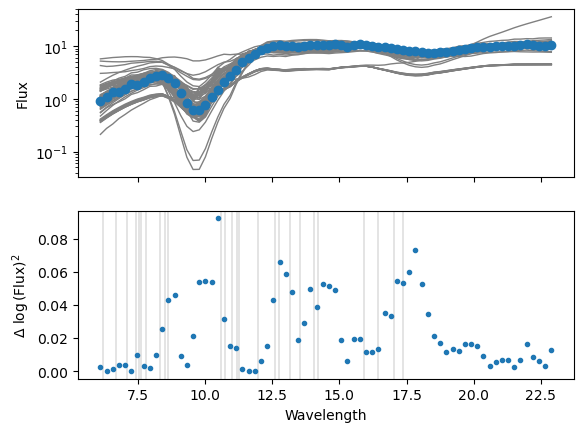

In [29]:
fig, axes = plt.subplots(2,1, sharex=True)
axes[0].semilogy(simpleforward.lam, np.exp(logmockdata_noise),"o", zorder=10)
axes[0].semilogy(simpleforward.lam, np.exp(post_sr_mean), lw=1)

for s in samples:
    axes[0].semilogy(simpleforward.lam, np.exp(simpleforward(s)), lw=1, color="grey")
for pha in PHAlistraw[:,0]:
    axes[1].axvline(pha, lw=0.3, color="grey")
axes[1].plot(simpleforward.lam, (logmockdata_noise-post_sr_mean)**2, ".")
axes[0].set_ylabel("Flux")
axes[1].set_xlabel("Wavelength")
axes[1].set_ylabel(r"$\Delta ~\log$(Flux)$^2$")

Text(0, 0.5, 'Temperature')

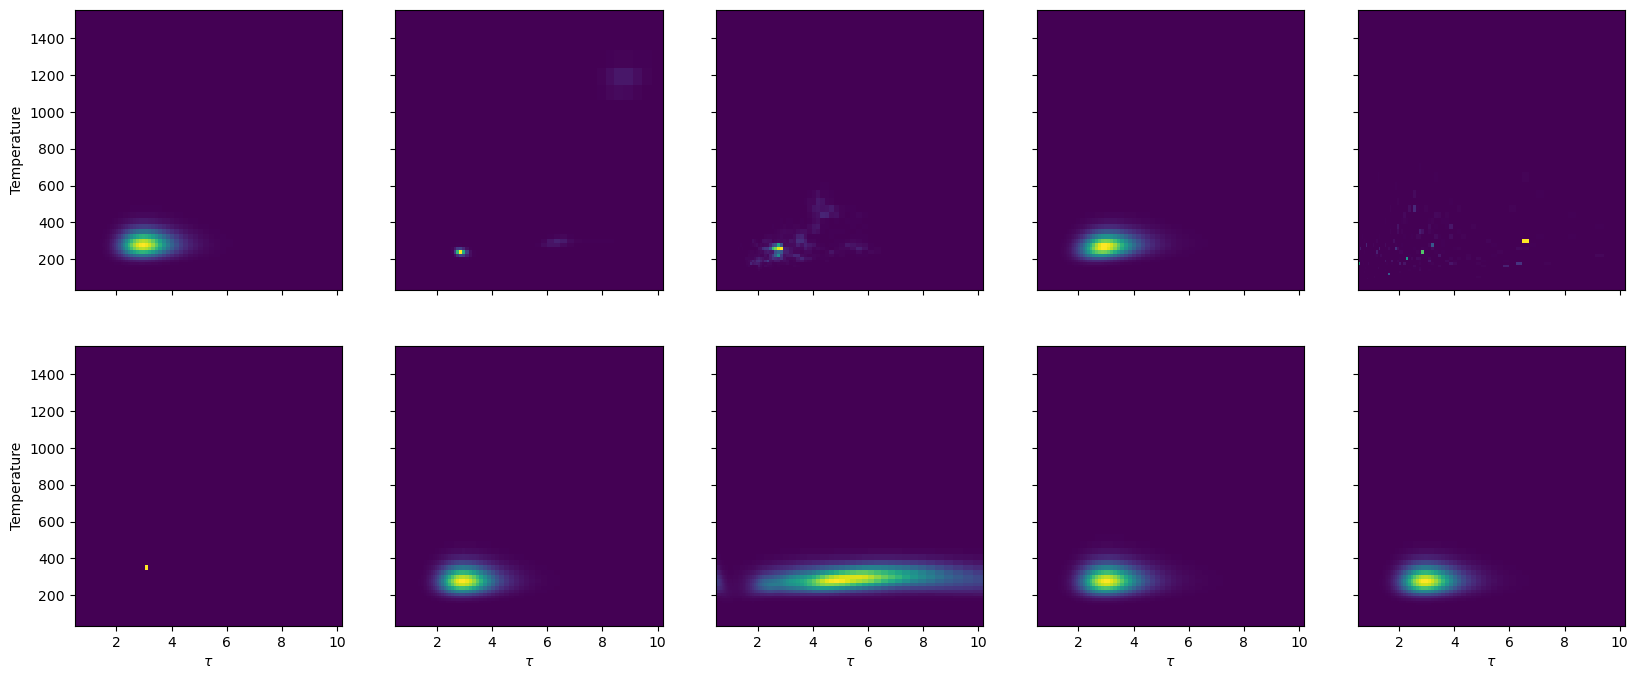

In [35]:
X, Y = np.meshgrid(simpleforward.tau_grid, simpleforward.temp_grid) 
fig, axes = plt.subplots(2,5, figsize=(5*4,2*4), sharex=True, sharey=True)
for num, s in enumerate(np.random.randint(0, len(samples), 10)):
    if num > 4:
        axes[1,num-5].pcolormesh(X, Y, jnp.exp(simplfield(samples[s])), norm="linear",)
        axes[1,num-5].set_xlabel(r"$\tau$")
    else:
        axes[0,num].pcolormesh(X, Y, jnp.exp(simplfield(samples[s])), norm="linear",)
        
axes[0,0].set_ylabel("Temperature")
axes[1,0].set_ylabel("Temperature")


# Extinction

Text(0, 0.5, '$\\Delta ~\\log$(Flux)$^2$')

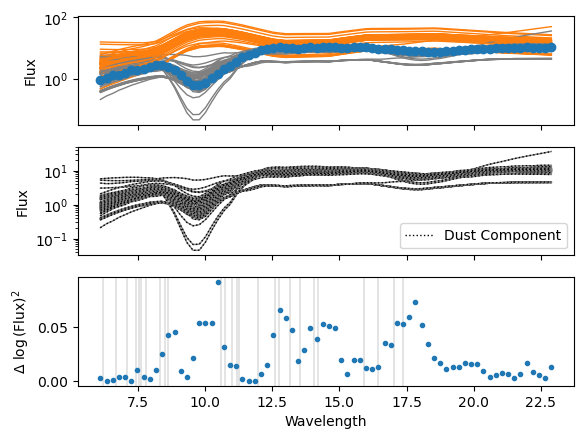

In [38]:
fig, axes = plt.subplots(3,1, sharex=True)
axes[0].semilogy(simpleforward.lam, np.exp(logmockdata_noise),"o", zorder=10)
axes[0].semilogy(simpleforward.lam, np.exp(post_sr_mean), lw=1)

for num, s in enumerate(samples):
    # np.savetxt("extinction_curves_sgrapx/sgra_pix_dustmodel_"+str(num)+".txt", np.array(simpleforward(s)))
    # np.savetxt("extinction_curves_sgrapx/sgra_pix_intrmodel_"+str(num)+".txt", np.array(simpleforward.get_intrinisic(s)))
    
    axes[0].semilogy(simpleforward.lam, np.exp(simpleforward(s)), lw=1, color="grey")
    axes[0].semilogy(simpleforward.lam, np.exp(simpleforward.get_intrinisic(s)), lw=1, color="C1")
    axes[1].semilogy(simpleforward.lam, np.exp(simpleforward(s)), lw=1, color="grey")
    axes[1].semilogy(simpleforward.lam, np.exp(simpleforward.get_dust(s)), lw=1, color="k", ls=":")
    
axes[1].semilogy(simpleforward.lam, np.exp(simpleforward.get_dust(s)), lw=1, color="k", ls=":", label="Dust Component")
axes[1].legend()
    
for pha in PHAlistraw[:,0]:
    axes[2].axvline(pha, lw=0.3, color="grey")
axes[2].plot(simpleforward.lam, (logmockdata_noise-post_sr_mean)**2, ".")
axes[0].set_ylabel("Flux")
axes[1].set_ylabel("Flux")

axes[2].set_xlabel("Wavelength")
axes[2].set_ylabel(r"$\Delta ~\log$(Flux)$^2$")

Text(0.5, 0, 'Wavelength')

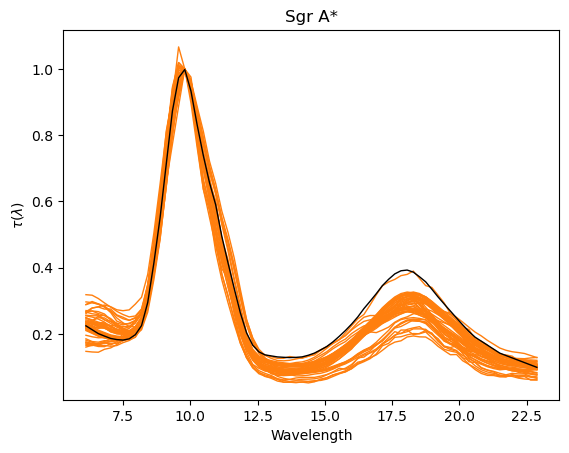

In [43]:
fig, axes = plt.subplots(sharex=True)
axes.set_title("Opacity Plot")
for s in samples:
    # print(np.nansum((simpleforward(s) - logmockdata)**2/noise_scl**2))
    if np.nansum((simpleforward(s) - logmockdata)**2/noise_scl**2) > 5000:
        continue
    tau = simpleforward.silicate_model * jnp.exp(tau_field(s))
    tau = tau/tau[simpleforward.idx98]
    axes.plot(simpleforward.lam, tau, lw=1, color="C1")
axes.plot(simpleforward.lam, simpleforward.silicate_model, lw=1, color="k")

axes.set_ylabel(r"$\tau(\lambda)$")
axes.set_xlabel("Wavelength")